# Лабораторная работа 3: Многослойный перцептрон (MLP) и нелинейные данные

 ## 1. Импорт библиотек и константы

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Константы
SEED = 42
EPOCHS = 1000
LEARNING_RATE = 0.01
HIDDEN_NEURONS = 4  # По заданию: 4 нейрона в скрытом слое

# Фиксация random seed для воспроизводимости
torch.manual_seed(SEED)
np.random.seed(SEED)

## 2. Генерация и визуализация данных (Задания 1-2)

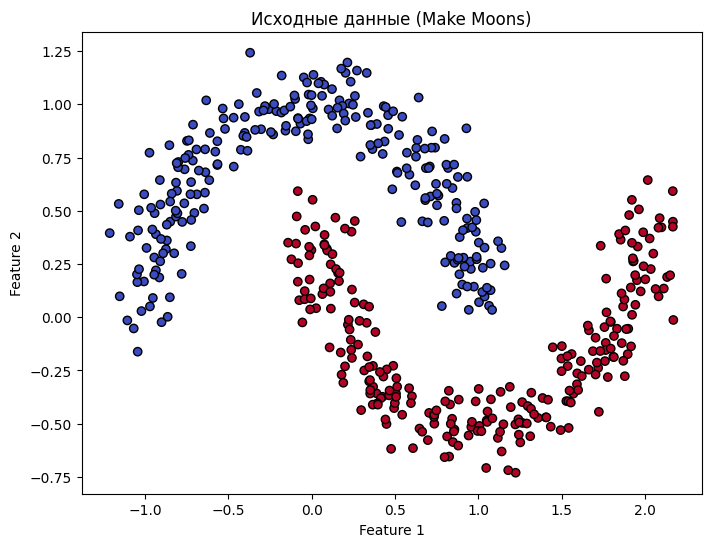

In [2]:
# 1. Генерация данных
# noise=0.1 добавляет немного "шума", чтобы точки не лежали идеально ровно
X, y = make_moons(n_samples=500, noise=0.1, random_state=SEED)

# 2. Визуализация данных
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title("Исходные данные (Make Moons)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

 ## 3. Создание MLP 

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # Слой 1: Вход (2) -> Скрытый (4)
        self.hidden = nn.Linear(2, HIDDEN_NEURONS)
        self.relu = nn.ReLU()
        
        # Слой 2: Скрытый (4) -> Выход (1)
        self.output = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Проход данных через сеть
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

# Инициализация модели
model = SimpleMLP()
print(model)

SimpleMLP(
  (hidden): Linear(in_features=2, out_features=4, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## 4. Разделение на train/test (80/20) 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1) # shape становится [N, 1]

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

## 5. Обучение модели 

In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_history = []

# Цикл обучения
for epoch in range(EPOCHS):
    # 1. Прямой проход
    y_pred = model(X_train_tensor)
    
    # 2. Вычисление ошибки
    loss = criterion(y_pred, y_train_tensor)
    
    # 3. Обратное распространение ошибки (Backprop)
    optimizer.zero_grad() # Обнуляем градиенты с прошлого шага
    loss.backward()       # Считаем новые градиенты
    optimizer.step()      # Обновляем веса
    
    loss_history.append(loss.item())
    
    # Вывод прогресса каждые 100 эпох
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.3041
Epoch [200/1000], Loss: 0.2321
Epoch [300/1000], Loss: 0.2226
Epoch [400/1000], Loss: 0.2189
Epoch [500/1000], Loss: 0.2171
Epoch [600/1000], Loss: 0.2160
Epoch [700/1000], Loss: 0.2153
Epoch [800/1000], Loss: 0.2149
Epoch [900/1000], Loss: 0.2146
Epoch [1000/1000], Loss: 0.2143


## 6. Оценка результатов

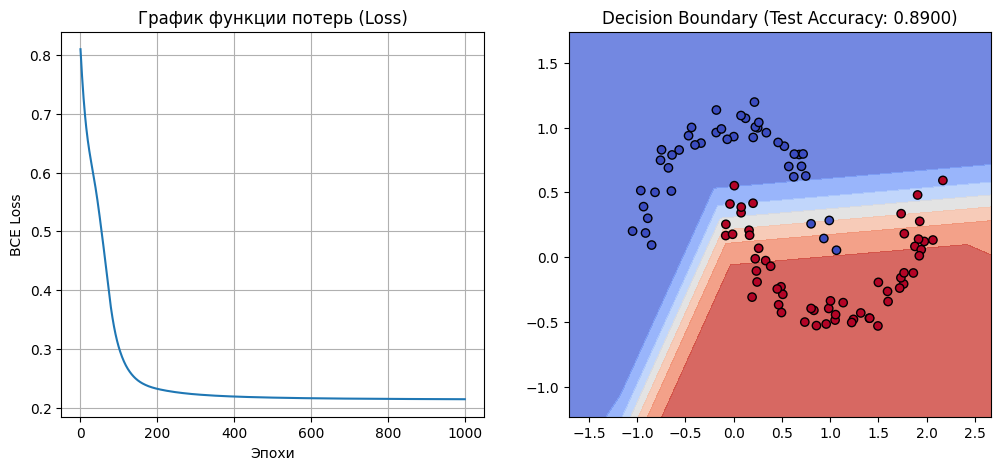

Итоговая точность на тесте: 89.00%


In [6]:
# 1. График Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("График функции потерь (Loss)")
plt.xlabel("Эпохи")
plt.ylabel("BCE Loss")
plt.grid(True)

# 2. Оценка точности
model.eval() # Переключаем в режим оценки (выключает dropout и т.д., если бы они были)
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    # Если вероятность > 0.5, то класс 1, иначе 0
    y_pred_class = (y_pred_test > 0.5).float()
    accuracy = accuracy_score(y_test, y_pred_class)

# 3. Визуализация границы решения (Decision Boundary)
plt.subplot(1, 2, 2)

# Создаем сетку точек по всей плоскости графика
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Превращаем сетку в тензор для предсказания
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

with torch.no_grad():
    Z = model(grid_tensor).reshape(xx.shape)

# Рисуем контуры вероятностей
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap='coolwarm')
plt.title(f"Decision Boundary (Test Accuracy: {accuracy:.4f})")
plt.show()

print(f"Итоговая точность на тесте: {accuracy * 100:.2f}%")